###Objetivo Geral
###Treinar uma rede neural (MLP) para prever a sobrevivência de passageiros do Titanic, explorando problemas de viés e aplicando técnicas de balanceamento e enriquecimento de dados para mitigar injustiças no modelo.

##Contexto do Dataset
##Dataset Titanic (Kaggle/Datascience Dojo)
Informações de passageiros do Titanic: nome, sexo, idade, classe social (Pclass), tarifa (Fare), número de parentes a bordo (SibSp e Parch), local de embarque, entre outros.

Variável-alvo: Survived (1 = sobreviveu, 0 = não sobreviveu)

Por que há viés nesse dataset?
Classe social (Pclass): Passageiros da 1ª classe tiveram mais acesso aos botes salva-vidas.

Sexo: Mulheres tiveram prioridade no resgate (“mulheres e crianças primeiro”).

Isso causa viés de representatividade — o modelo pode aprender padrões sociais injustos (ex: associar “ser homem” ou “ser da 3ª classe” com menor chance de sobrevivência).

In [313]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
sns.set(style="whitegrid")

In [314]:
# Carrega o conjunto de dados Titanic diretamente de um repositório no GitHub
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleciona apenas as colunas 'Sex', 'Pclass' e 'Survived', e remove linhas com valores ausentes (NaN)
df = df[['Sex', 'Pclass', 'Survived']].dropna()

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Sexo'] = df['Sex'].map({0: 'Homem', 1: 'Mulher'})
df['Classe'] = df['Pclass'].astype(str)
df['Sobreviveu'] = df['Survived'].map({0: 'Não', 1: 'Sim'})

C:\Users\jmarques\AppData\Local\Temp\ipykernel_10440\3978351522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='Set2')


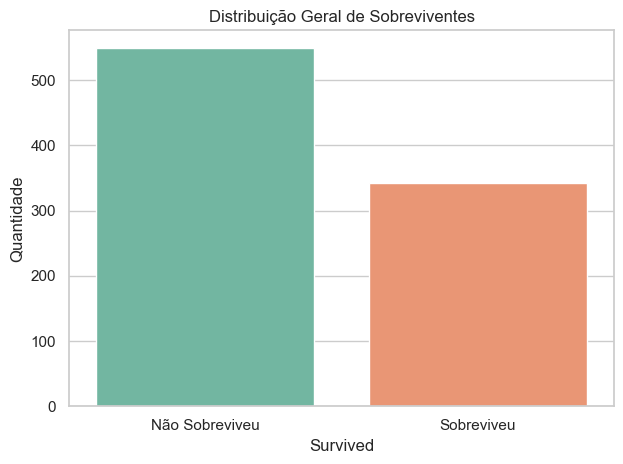

In [315]:
# plot da distribuição geral de sobreviventes
sns.countplot(x='Survived', data=df, palette='Set2')
plt.title("Distribuição Geral de Sobreviventes")
plt.xticks([0, 1], ['Não Sobreviveu', 'Sobreviveu'])
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

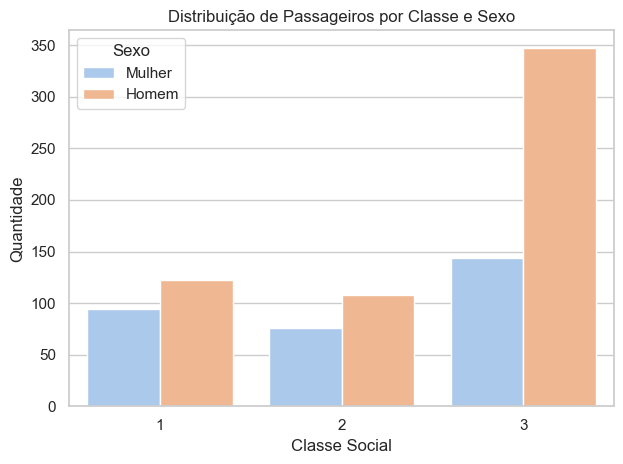

In [316]:
# plot da distribuição por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df, palette='pastel')
plt.title("Distribuição de Passageiros por Classe e Sexo")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

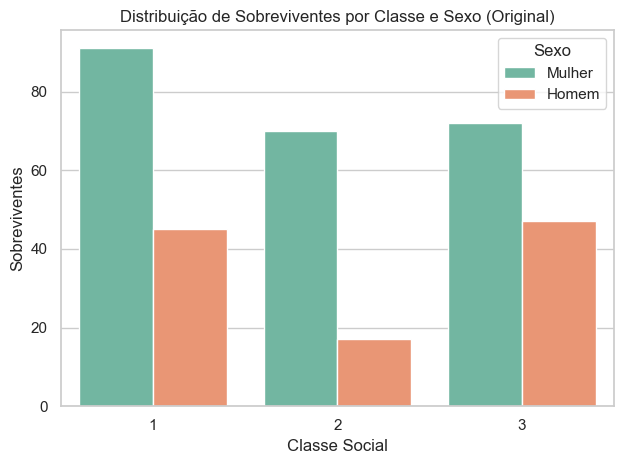

In [317]:
# Sobreviventes por classe e sexo
sobreviventes = df[df['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes, palette='Set2')
plt.title("Distribuição de Sobreviventes por Classe e Sexo (Original)")
plt.xlabel("Classe Social")
plt.ylabel("Sobreviventes")
plt.tight_layout()
plt.show()

C:\Users\jmarques\AppData\Local\Temp\ipykernel_10440\2932129216.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')


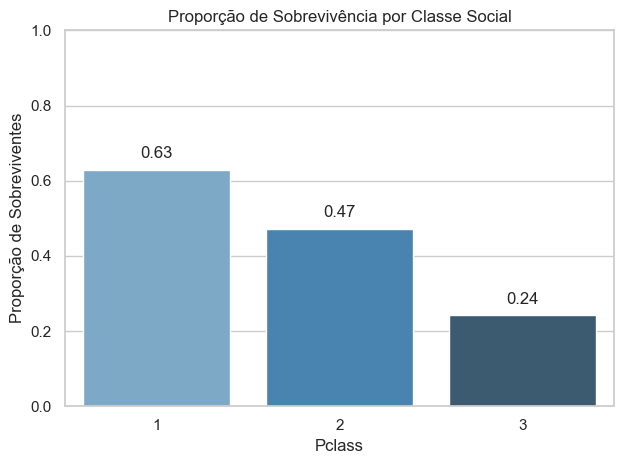

In [318]:
# Proporção de sobreviventes por classe
proporcao = df.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')
plt.title("Proporção de Sobrevivência por Classe Social")
plt.ylabel("Proporção de Sobreviventes")
plt.ylim(0, 1)
for i, val in enumerate(proporcao['Survived']):
    plt.text(i, val + 0.03, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

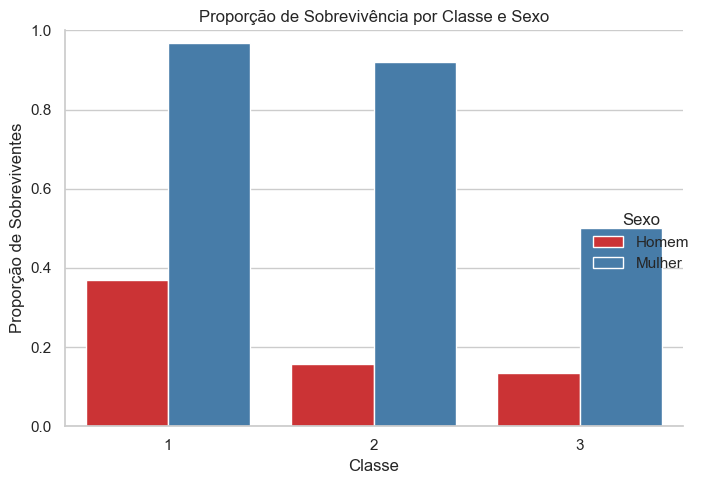

In [319]:
# Proporção de sobreviventes por classe e sexo
proporcao_sexo_classe = df.groupby(['Classe', 'Sexo'])['Survived'].mean().reset_index()
sns.catplot(data=proporcao_sexo_classe, x='Classe', y='Survived', hue='Sexo', kind='bar', palette='Set1', height=5, aspect=1.2)
plt.title("Proporção de Sobrevivência por Classe e Sexo")
plt.ylim(0, 1)
plt.ylabel("Proporção de Sobreviventes")
plt.tight_layout()
plt.show()

In [320]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Seleciona as variáveis independentes e alvo
X = df[['Sex', 'Pclass']]
y = df['Survived']

# Divide os dados em treino, validação e teste (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

# Balanceamento apenas no treino
df_train = X_train.copy()
df_train['Survived'] = y_train

df_train_bal = pd.DataFrame()
for pclass in df_train['Pclass'].unique():
    subset = df_train[df_train['Pclass'] == pclass]
    survived = subset[subset['Survived'] == 1]
    not_survived = subset[subset['Survived'] == 0]
    min_len = min(len(survived), len(not_survived))
    balanced_subset = pd.concat([
        resample(survived, replace=False, n_samples=min_len, random_state=42),
        resample(not_survived, replace=False, n_samples=min_len, random_state=42)
    ])
    df_train_bal = pd.concat([df_train_bal, balanced_subset])

df_train_bal = df_train_bal.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = df_train_bal[['Sex', 'Pclass']]
y_train_bal = df_train_bal['Survived']

# Normalização
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


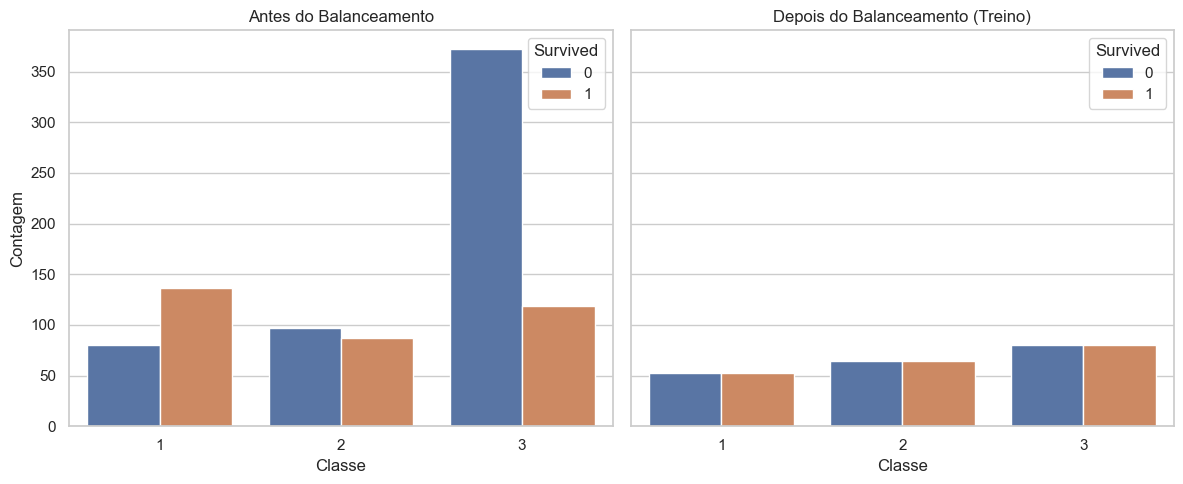

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adiciona a coluna Survived ao X original para visualização
df_original = X.copy()
df_original['Survived'] = y

# Antes do balanceamento
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(data=df_original, x='Pclass', hue='Survived', ax=axes[0])
axes[0].set_title('Antes do Balanceamento')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Contagem')

# Depois do balanceamento (após correção)
df_train_bal_plot = X_train_bal.copy()
df_train_bal_plot['Survived'] = y_train_bal

sns.countplot(data=df_train_bal_plot, x='Pclass', hue='Survived', ax=axes[1])
axes[1].set_title('Depois do Balanceamento (Treino)')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


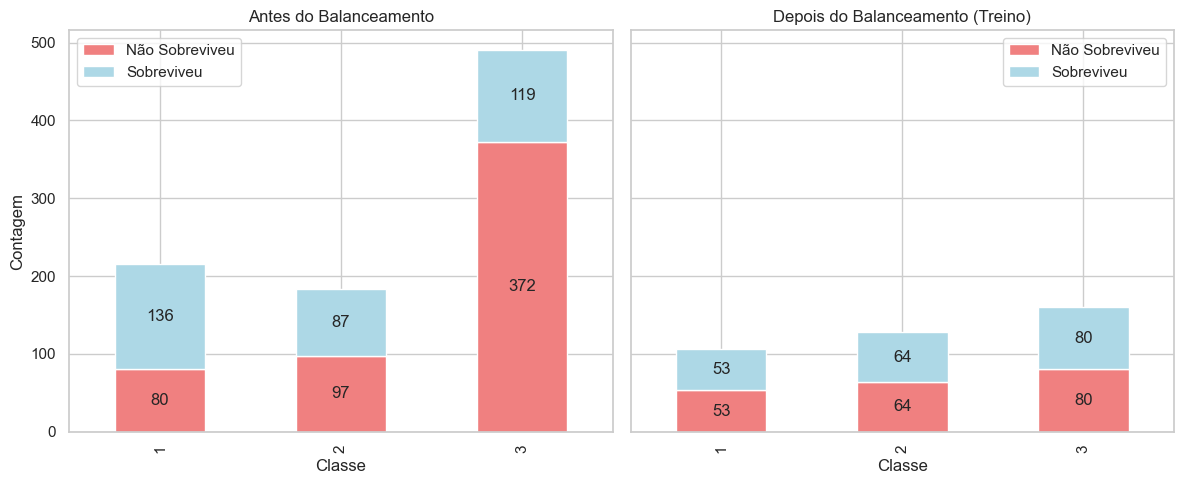

In [322]:
import matplotlib.pyplot as plt

# Agrupamento antes do balanceamento
df_original = X.copy()
df_original['Survived'] = y
counts_original = df_original.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0)
counts_original.columns = ['Não Sobreviveu', 'Sobreviveu']

# Agrupamento depois do balanceamento
df_bal = X_train_bal.copy()
df_bal['Survived'] = y_train_bal
counts_bal = df_bal.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0)
counts_bal.columns = ['Não Sobreviveu', 'Sobreviveu']

# Criar figuras lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Antes
ax1 = counts_original.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], ax=axes[0])
axes[0].set_title("Antes do Balanceamento")
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("Contagem")
axes[0].set_xticks(range(len(counts_original)))
axes[0].set_xticklabels(counts_original.index)
for container in ax1.containers:
    ax1.bar_label(container, label_type='center')

# Depois
ax2 = counts_bal.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], ax=axes[1])
axes[1].set_title("Depois do Balanceamento (Treino)")
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("")
axes[1].set_xticks(range(len(counts_bal)))
axes[1].set_xticklabels(counts_bal.index)
for container in ax2.containers:
    ax2.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()


Balanceamento de Dados (Fairness Básica por Classe Social)
O que foi feito:
O balanceamento foi aplicado apenas na base de treino, respeitando a divisão entre treino, validação e teste.
Dentro da base de treino, igualou-se a quantidade de sobreviventes e não sobreviventes em cada classe social (Pclass), criando um conjunto equilibrado para o aprendizado do modelo.

Por que isso é importante?
Sem balanceamento, o modelo tende a favorecer os grupos majoritários durante o treinamento, aprendendo padrões enviesados.
Ao aplicar o balanceamento apenas no treino, oferecemos peso igual aos grupos desbalanceados, sem comprometer a avaliação justa do modelo em validação e teste.
Isso ajuda a evitar que o modelo “ignore” minorias — como os poucos sobreviventes da 3ª classe — promovendo maior equidade no aprendizado.

Pré-processamento: Divisão e Normalização
Divisão em Treino, Validação e Teste
Os dados foram divididos em três conjuntos:

70% para treino,

15% para validação,

15% para teste,
utilizando o train_test_split.

Essa separação garante que o modelo seja treinado em um subconjunto dos dados e avaliado em exemplos nunca vistos, simulando um cenário de uso real.

Normalização (StandardScaler)
Os dados foram escalados com StandardScaler, que transforma cada variável para ter média 0 e desvio padrão 1.

Essa etapa é essencial para redes neurais, pois evita que variáveis com escala maior (como Fare) dominem o cálculo dos gradientes, o que:
-acelera o treinamento,
-melhora a convergência,
-e ajuda a evitar instabilidades numéricas.

Treinamento da Rede Neural (MLPClassifier)
Arquitetura do Modelo
Modelo: MLPClassifier (Multi-Layer Perceptron)

Camadas ocultas: duas camadas com 16 e 8 neurônios, respectivamente

Função de ativação: ReLU (Rectified Linear Unit)

Fórmula: f(x) = max(0, x)

Introduz não-linearidade no modelo

Acelera o aprendizado e evita o problema do gradiente desvanecido (que afeta funções como sigmoid ou tanh)

Permite que o modelo aprenda relações complexas entre as variáveis

Otimizador:
Adam (Adaptive Moment Estimation)
Ajusta os pesos de forma adaptativa
É eficiente e robusto mesmo com muitos parâmetros

Época 0: Loss = 0.8066, Acurácia Treino = 0.4188, Validação = 0.3582
Época 10: Loss = 0.7456, Acurácia Treino = 0.4188, Validação = 0.3582
Época 20: Loss = 0.7012, Acurácia Treino = 0.5000, Validação = 0.3881
Época 30: Loss = 0.6678, Acurácia Treino = 0.5939, Validação = 0.4328
Época 40: Loss = 0.6372, Acurácia Treino = 0.6751, Validação = 0.7313
Época 50: Loss = 0.6093, Acurácia Treino = 0.7944, Validação = 0.8209
Época 60: Loss = 0.5835, Acurácia Treino = 0.7944, Validação = 0.8209
Época 70: Loss = 0.5578, Acurácia Treino = 0.7944, Validação = 0.8209
Época 80: Loss = 0.5360, Acurácia Treino = 0.7944, Validação = 0.8209
Época 90: Loss = 0.5181, Acurácia Treino = 0.7944, Validação = 0.8209
Época 100: Loss = 0.5047, Acurácia Treino = 0.7944, Validação = 0.8209
Época 110: Loss = 0.4955, Acurácia Treino = 0.7944, Validação = 0.8209
Época 120: Loss = 0.4900, Acurácia Treino = 0.7944, Validação = 0.8209
Época 130: Loss = 0.4866, Acurácia Treino = 0.7944, Validação = 0.8209
Época 140: Loss =

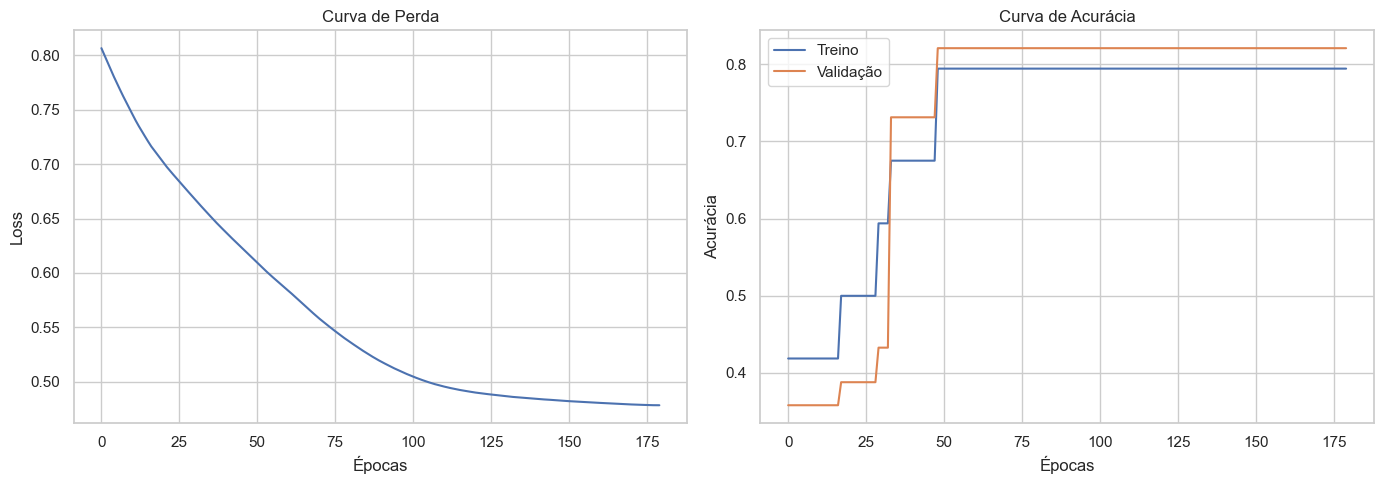

In [323]:

# Inicializar o modelo
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=1,           # Uma época por vez
    warm_start=True,      # Continua treinamento anterior
    random_state=42,
    early_stopping=False
)

# Listas para armazenar histórico
loss_curve = []
train_acc_curve = []
val_acc_curve = []

epochs = 180

# Treinamento manual
for epoch in range(epochs):
    mlp.fit(X_train_bal_scaled, y_train_bal)

    # Loss (MLPClassifier armazena o loss após .fit)
    loss_curve.append(mlp.loss_)

    # Acurácia no treino
    y_train_pred = mlp.predict(X_train_bal_scaled)
    train_acc = accuracy_score(y_train_bal, y_train_pred)
    train_acc_curve.append(train_acc)

    # Acurácia na validação
    y_val_pred = mlp.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_acc_curve.append(val_acc)

    # Print a cada 10 épocas
    if epoch % 10 == 0:
        print(f"Época {epoch}: Loss = {mlp.loss_:.4f}, Acurácia Treino = {train_acc:.4f}, Validação = {val_acc:.4f}")

# Plotar curvas
plt.figure(figsize=(14, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(loss_curve, label='Loss (Treino)')
plt.title("Curva de Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(train_acc_curve, label='Treino')
plt.plot(val_acc_curve, label='Validação')
plt.title("Curva de Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [324]:
# Avaliação

y_pred = mlp.predict(X_test_scaled)  

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}") 
print("\nRelatório de Classificação:") 
print(classification_report(y_test, y_pred))  

Acurácia: 0.7537

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        83
           1       0.70      0.61      0.65        51

    accuracy                           0.75       134
   macro avg       0.74      0.73      0.73       134
weighted avg       0.75      0.75      0.75       134



###Métricas do Modelo
Após treinar o modelo, é importante verificar se ele está realmente fazendo boas previsões. Para isso, usamos mais do que apenas a acurácia.

Accuracy (Acurácia): mede a proporção de previsões corretas em relação ao total. Embora útil, pode ser enganosa se uma classe tiver muito mais exemplos que a outra.

Precision (Precisão): indica, entre os casos que o modelo previu como positivos (por exemplo, "sobreviveu"), quantos realmente eram positivos. Alta precisão significa poucos falsos positivos.Precision= VP/VP+FP

Recall (Revocação ou Sensibilidade): mede, entre os casos que realmente eram positivos, quantos o modelo conseguiu identificar corretamente. Alta revocação significa poucos falsos negativos. Recall = VP/VP+FN

F1-Score: é a média harmônica entre precisão e recall. É útil para equilibrar os dois, principalmente quando é importante tanto identificar os positivos quanto evitar falsos alarmes.
F1-Score = 2*(Precision*Recall / Precision+Recall)
Support (Suporte): representa a quantidade real de exemplos de cada classe no conjunto de testes, ajudando a interpretar as métricas anteriores.

Essas métricas juntas fornecem uma visão mais completa da qualidade do modelo, permitindo entender não apenas quantas previsões foram corretas, mas como elas foram corretas (ou erradas).

C:\Users\jmarques\AppData\Local\Temp\ipykernel_10440\794109156.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')


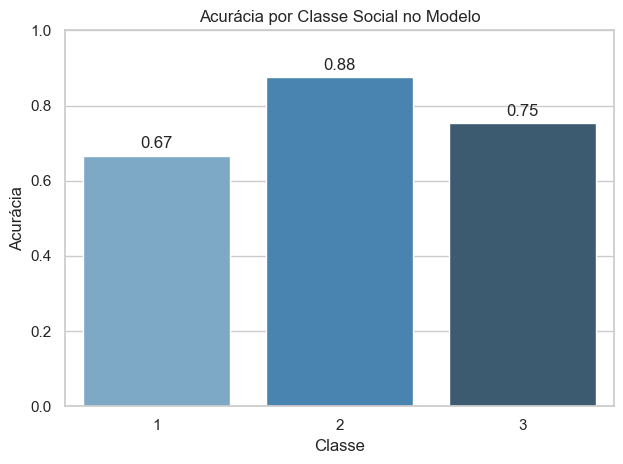

In [325]:
def avaliar_justica(model, X_test, y_test, original_df, X_test_scaled):
    # Garantir que os índices estejam corretos
    X_test_df = X_test.copy()
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = model.predict(X_test_scaled)

    # Recuperar a Pclass correta do dataframe original
    X_test_df['Pclass'] = original_df.loc[X_test.index, 'Pclass'].values

    resultados = []
    for p in sorted(X_test_df['Pclass'].unique()):
        subset = X_test_df[X_test_df['Pclass'] == p]
        acc = accuracy_score(subset['Survived_Real'], subset['Survived_Pred'])
        resultados.append({'Classe': p, 'Acurácia': acc, 'Total': len(subset)})

    # Exibir gráfico
    df_result = pd.DataFrame(resultados)
    sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')
    plt.ylim(0, 1)
    plt.title("Acurácia por Classe Social no Modelo")
    for index, row in df_result.iterrows():
        plt.text(index, row.Acurácia + 0.02, f"{row.Acurácia:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
avaliar_justica(mlp, X_test, y_test, df, X_test_scaled)


In [326]:
# Carregar e preparar o dataset com features extras
df_full = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleção inicial das colunas
df_full = df_full[['Name', 'Sex', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked', 'Survived']]

# Converter sexo para formato numérico
df_full['Sex'] = df_full['Sex'].map({'male': 0, 'female': 1})

# Extrair o título do nome
df_full['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
df_full['Title'] = df_full['Title'].apply(lambda t: t if t in common_titles else 'Other')

# Preencher idade com média por título
mean_age_by_title = df_full.groupby('Title')['Age'].mean()
df_full['Age'] = df_full.apply(
    lambda row: mean_age_by_title[row['Title']] if pd.isnull(row['Age']) else row['Age'],
    axis=1
)

# Remover os poucos casos restantes com NaN (ex: Embarked)
df_full = df_full.dropna()

# One-hot encoding para variáveis categóricas
df_full = pd.get_dummies(df_full, columns=['Embarked', 'Title'], drop_first=True)

# Visualizar as primeiras linhas para checagem
print(df_full.head())


<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\jmarques\AppData\Local\Temp\ipykernel_10440\913149916.py:11: SyntaxWarning: invalid escape sequence '\.'
  df_full['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


                                                Name  Sex  Pclass   Age  \
0                            Braund, Mr. Owen Harris    0       3  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1       1  38.0   
2                             Heikkinen, Miss. Laina    1       3  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1       1  35.0   
4                           Allen, Mr. William Henry    0       3  35.0   

      Fare  SibSp  Parch  Survived  Embarked_Q  Embarked_S  Title_Miss  \
0   7.2500      1      0         0       False        True       False   
1  71.2833      1      0         1       False       False       False   
2   7.9250      0      0         1       False        True        True   
3  53.1000      1      0         1       False        True       False   
4   8.0500      0      0         0       False        True       False   

   Title_Mr  Title_Mrs  Title_Other  
0      True      False        False  
1     False       True      

In [327]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar X e y ANTES da normalização
X = df_full.drop(columns=['Name', 'Survived'])
y = df_full['Survived']

# Salvar os nomes das colunas antes de virar array
feature_cols = X.columns.tolist()
# Normalização ANTES da divisão
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir os dados já normalizados (70% treino, 15% val, 15% teste)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

# Mostrar shapes
print(f"Shape treino: {X_train.shape}")
print(f"Shape validação: {X_val.shape}")
print(f"Shape teste: {X_test.shape}")

Shape treino: (622, 12)
Shape validação: (133, 12)
Shape teste: (134, 12)


In [328]:
import numpy as np

# Reconstruir DataFrame do treino para balancear (com os nomes das colunas originais)
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_train_df['Survived'] = y_train.values

# Separar classes
survived = X_train_df[X_train_df['Survived'] == 1]
not_survived = X_train_df[X_train_df['Survived'] == 0]

# Balancear com base na menor classe
min_len = min(len(survived), len(not_survived))
df_train_bal = pd.concat([
    resample(survived, n_samples=min_len, random_state=42),
    resample(not_survived, n_samples=min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Separar X e y balanceados
X_train_bal_scaled = df_train_bal.drop(columns=['Survived']).values
y_train_bal = df_train_bal['Survived'].values

# Shapes finais
print(f"Treino balanceado: {X_train_bal_scaled.shape}")
print(f"Validação: {X_val.shape}")
print(f"Teste: {X_test.shape}")


Treino balanceado: (476, 12)
Validação: (133, 12)
Teste: (134, 12)


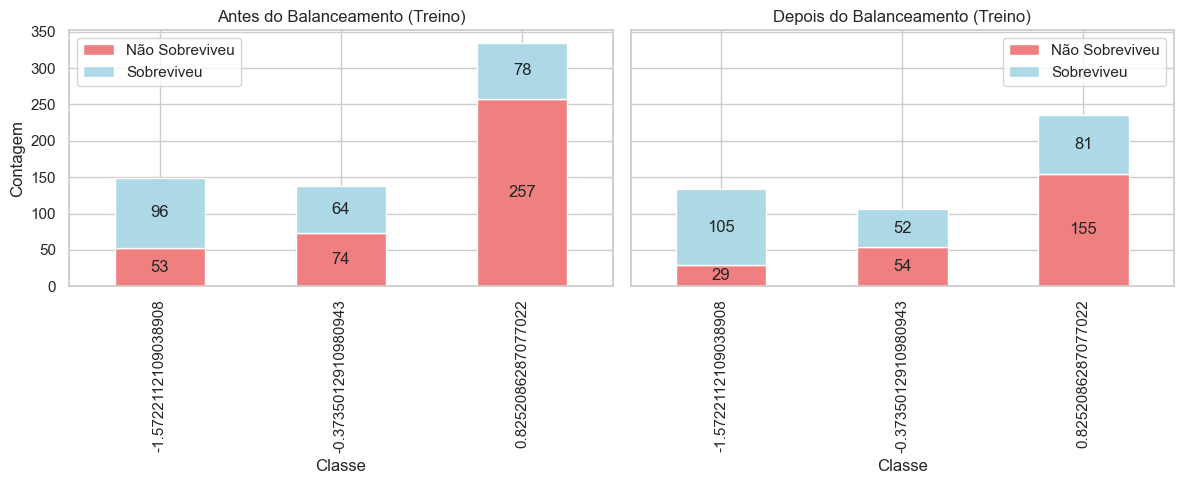

In [329]:
import matplotlib.pyplot as plt

# Reconstruir os dataframes para visualização
X_train_df_vis = X_train_df.copy()
df_train_bal_vis = df_train_bal.copy()

X_train_df_vis['Classe'] = X_train_df_vis['Pclass']
df_train_bal_vis['Classe'] = df_train_bal_vis['Pclass']

# Agrupamento antes do balanceamento
counts_before = X_train_df_vis.groupby('Classe')['Survived'].value_counts().unstack().fillna(0)
counts_before.columns = ['Não Sobreviveu', 'Sobreviveu']

# Agrupamento depois do balanceamento
counts_after = df_train_bal_vis.groupby('Classe')['Survived'].value_counts().unstack().fillna(0)
counts_after.columns = ['Não Sobreviveu', 'Sobreviveu']

# Plotar gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Antes
ax1 = counts_before.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], ax=axes[0])
axes[0].set_title("Antes do Balanceamento (Treino)")
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("Contagem")
axes[0].set_xticks(range(len(counts_before)))
axes[0].set_xticklabels(counts_before.index)
for container in ax1.containers:
    ax1.bar_label(container, label_type='center')

# Depois
ax2 = counts_after.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], ax=axes[1])
axes[1].set_title("Depois do Balanceamento (Treino)")
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("")
axes[1].set_xticks(range(len(counts_after)))
axes[1].set_xticklabels(counts_after.index)
for container in ax2.containers:
    ax2.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()


In [330]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Inicializar o modelo
mlp_enriched = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=1,            # Treinaremos uma época por vez
    warm_start=True,       # Permite continuar o treinamento
    random_state=42,
    early_stopping=False
)

# Listas para armazenar histórico
train_loss_curve = []
val_loss_curve = []
train_f1_curve = []
val_f1_curve = []

epochs = 250

# Treinamento manual com validação
for epoch in range(epochs):
    mlp_enriched.fit(X_train, y_train)
    
    # Registrar perda do treino
    train_loss_curve.append(mlp_enriched.loss_)

    # F1-score treino
    y_train_pred = mlp_enriched.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='binary')
    train_f1_curve.append(train_f1)

    # F1-score validação
    y_val_pred = mlp_enriched.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='binary')
    val_f1_curve.append(val_f1)
    
  
    val_loss_curve.append(mlp_enriched.loss_)

    if epoch % 10 == 0:
        print(f"Época {epoch}: Train Loss = {mlp_enriched.loss_:.4f}, Train F1 = {train_f1:.4f}, Val F1 = {val_f1:.4f}")





Época 0: Train Loss = 0.7328, Train F1 = 0.5400, Val F1 = 0.5506
Época 10: Train Loss = 0.6502, Train F1 = 0.5714, Val F1 = 0.5814
Época 20: Train Loss = 0.5771, Train F1 = 0.7388, Val F1 = 0.7091
Época 30: Train Loss = 0.5030, Train F1 = 0.7716, Val F1 = 0.7379
Época 40: Train Loss = 0.4404, Train F1 = 0.7815, Val F1 = 0.7379
Época 50: Train Loss = 0.3936, Train F1 = 0.7836, Val F1 = 0.7000
Época 60: Train Loss = 0.3724, Train F1 = 0.7963, Val F1 = 0.7083
Época 70: Train Loss = 0.3629, Train F1 = 0.8000, Val F1 = 0.6947
Época 80: Train Loss = 0.3580, Train F1 = 0.8037, Val F1 = 0.6947
Época 90: Train Loss = 0.3551, Train F1 = 0.8028, Val F1 = 0.6947
Época 100: Train Loss = 0.3530, Train F1 = 0.8019, Val F1 = 0.6947
Época 110: Train Loss = 0.3515, Train F1 = 0.8019, Val F1 = 0.6947
Época 120: Train Loss = 0.3503, Train F1 = 0.8056, Val F1 = 0.6947
Época 130: Train Loss = 0.3493, Train F1 = 0.8056, Val F1 = 0.6947
Época 140: Train Loss = 0.3483, Train F1 = 0.8084, Val F1 = 0.6947
Época 

In [331]:
# Avaliação no Teste

# Avaliação no Teste usando scikit-learn corretamente

y_test_pred = mlp_enriched.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)

print(f"\nF1-Score no Teste: {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))




F1-Score no Teste: 0.7111
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        83
           1       0.82      0.63      0.71        51

    accuracy                           0.81       134
   macro avg       0.81      0.77      0.78       134
weighted avg       0.81      0.81      0.80       134



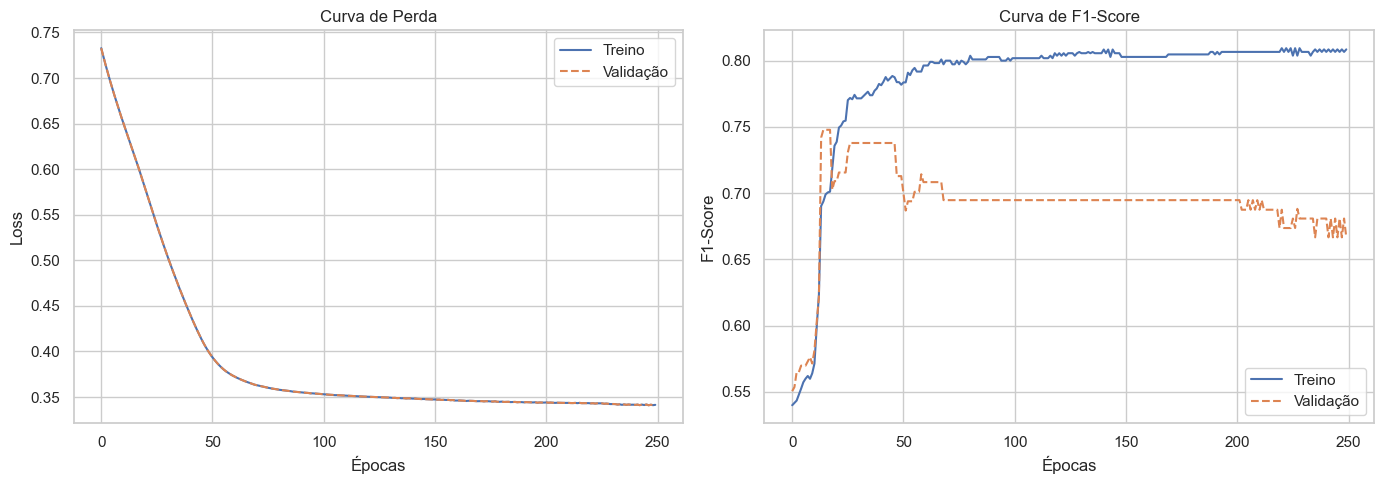

In [332]:
plt.figure(figsize=(14, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(train_loss_curve, label='Treino')
plt.plot(val_loss_curve, label='Validação', linestyle='--')
plt.title("Curva de Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Curva de F1-score
plt.subplot(1, 2, 2)
plt.plot(train_f1_curve, label='Treino')
plt.plot(val_f1_curve, label='Validação', linestyle='--')
plt.title("Curva de F1-Score")
plt.xlabel("Épocas")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\jmarques\AppData\Local\Temp\ipykernel_10440\3615614932.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Classe', y='F1-Score', palette='Blues_d')


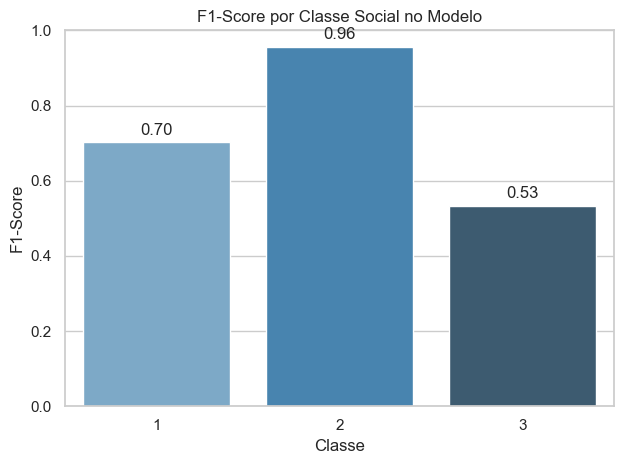

In [333]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def avaliar_justica(model, X_test_scaled, y_test, df_original_completo):
    # Acessar o índice correto
    indices_teste = y_test.index

    # Criar DataFrame com previsões e Pclass original
    X_test_df = pd.DataFrame(X_test_scaled, index=indices_teste)
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = model.predict(X_test_scaled)
    X_test_df['Pclass'] = df_original_completo.loc[indices_teste, 'Pclass'].values

    # Avaliar F1-score por classe
    resultados = []
    for p in [1, 2, 3]:
        subset = X_test_df[X_test_df['Pclass'] == p]
        if len(subset) > 0:
            f1 = f1_score(subset['Survived_Real'], subset['Survived_Pred'], average='binary', zero_division=0)
        else:
            f1 = 0
        resultados.append({'Classe': p, 'F1-Score': f1, 'Total': len(subset)})

    # Plotar gráfico
    df_result = pd.DataFrame(resultados)
    sns.barplot(data=df_result, x='Classe', y='F1-Score', palette='Blues_d')
    plt.ylim(0, 1)
    plt.title("F1-Score por Classe Social no Modelo")
    for index, row in df_result.iterrows():
        plt.text(index, row['F1-Score'] + 0.02, f"{row['F1-Score']:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
avaliar_justica(mlp_enriched, X_test, y_test, df_full)


In [334]:
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar novos passageiros
df_novos = pd.read_csv('novos_passageiros.csv')

# Selecionar e copiar colunas relevantes
novo_df = df_novos[['Name', 'Sex', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked']].copy()

# Codificar sexo (igual ao treino)
novo_df['Sex'] = novo_df['Sex'].map({'male': 0, 'female': 1})

# Extrair título do nome
novo_df['Title'] = novo_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
novo_df['Title'] = novo_df['Title'].apply(lambda t: t if t in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Other')

# Aplicar os mesmos imputadores usados no treino
novo_df[['Age', 'Fare']] = imputer_num.transform(novo_df[['Age', 'Fare']])
novo_df[['Embarked']] = imputer_cat.transform(novo_df[['Embarked']])

# One-hot encoding para Embarked e Title, drop_first como no treino
novo_df = pd.get_dummies(novo_df, columns=['Embarked', 'Title'], drop_first=True)

colunas_modelo = X.columns.tolist()  # ordem e nomes corretos

for col in colunas_modelo:
    if col not in novo_df.columns:
        novo_df[col] = 0

novo_df = novo_df[colunas_modelo]

novodf_scaled = scaler.transform(novo_df)


<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
C:\Users\jmarques\AppData\Local\Temp\ipykernel_10440\2282735733.py:16: SyntaxWarning: invalid escape sequence '\.'
  novo_df['Title'] = novo_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [335]:
# Fazer predições com o modelo treinado
novas_predicoes = mlp_enriched.predict(novodf_scaled)
probabilidades = mlp_enriched.predict_proba(novodf_scaled)

# Adicionar as predições ao DataFrame original
df_resultado = df_orig.copy()
df_resultado.loc[novo_df.index, 'Predicted_Survived'] = novas_predicoes
df_resultado.loc[novo_df.index, 'Prob_Survived'] = probabilidades[:, 1]

# Salvar o DataFrame com as predições
df_resultado.to_csv("predicoes_passageiros.csv", index=False)

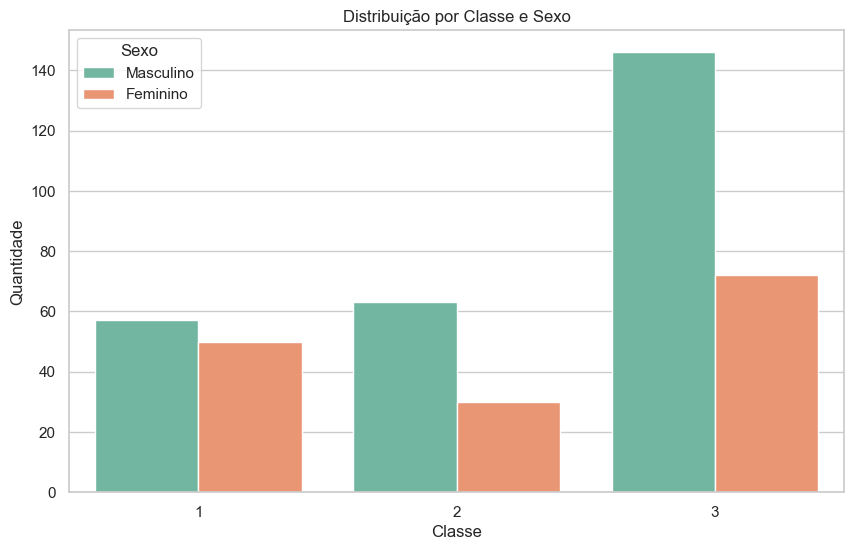

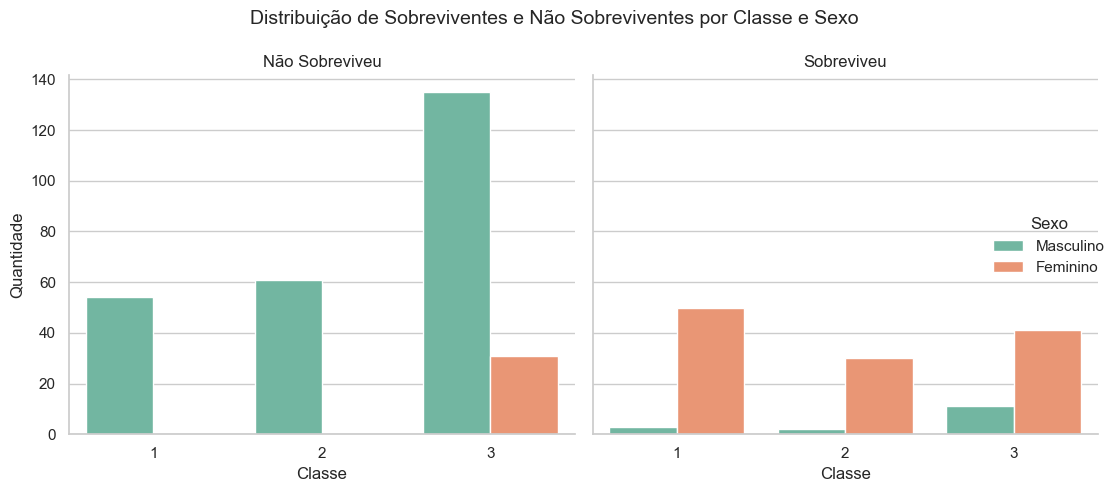

In [336]:
# Preparar o DataFrame para os gráficos
df_plot = df_resultado.copy()

# Mapear os valores de sobrevivência para texto
df_plot['Predicted_Survived'] = df_plot['Predicted_Survived'].map({0: 'Não Sobreviveu', 1: 'Sobreviveu'})

# Mapear sexo para texto
if df_plot['Sex'].dtype != object:
    df_plot['Sex'] = df_plot['Sex'].map({0: 'Masculino', 1: 'Feminino'})
else:
    df_plot['Sex'] = df_plot['Sex'].map({'male': 'Masculino', 'female': 'Feminino'})

# Filtrar apenas linhas com predições válidas
df_plot = df_plot.dropna(subset=['Predicted_Survived'])

# Plot 1 - Distribuição por classe e sexo
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_plot, 
    x='Pclass', 
    hue='Sex', 
    palette='Set2',
    hue_order=['Masculino', 'Feminino'],
    dodge=True,
    order=sorted(df_plot['Pclass'].unique())
)
plt.title('Distribuição por Classe e Sexo')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.legend(title='Sexo')
plt.show()

# Plot 2 - Separação por sobrevivência prevista
g = sns.catplot(
    data=df_plot, 
    kind='count',
    x='Pclass', 
    hue='Sex', 
    col='Predicted_Survived',
    palette='Set2', 
    height=5, 
    aspect=1
)

g.set_axis_labels("Classe", "Quantidade")
g.set_titles("{col_name}")
g._legend.set_title("Sexo")
g.fig.suptitle("Distribuição de Sobreviventes e Não Sobreviventes por Classe e Sexo", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


###Mitigação de Viés via Penalização Direcionada de Pesos
Nesta etapa, foi aplicada uma técnica de mitigação de viés baseada na penalização direta dos pesos da rede neural associados a variáveis sensíveis.

O foco foi reduzir a dependência do modelo em relação às variáveis Fare e Pclass, que são as features que criam uma injustiça pos são relacionadas dieramente a condição socioeconômica dos passageiros do Titanic. Essas variáveis estão fortemente correlacionadas com as chances de sobrevivência, devido a desigualdades históricas.

Se o modelo aprender padrões baseados exclusivamente nessas variáveis, ele tende a reproduzir um comportamento enviesado, favorecendo certos grupos sociais de forma desproporcional.

####Como foi implementado?
Foi adicionada uma penalização diretamente sobre os pesos da primeira camada da rede neural ligados às variáveis Fare e Pclass.

Essa penalização segue a fórmula:
Penalização=λ x (∑(pesos da Fare)^2 + ∑(pesos da Pclass)^2)
 
λ (lambda): Fator de penalização (hiperparâmetro)

Pesos penalizados: Somente os pesos conectados às features Fare e Pclass na primeira camada

####Por que essa abordagem funciona?
O treinamento da rede com essa penalização gera um gradiente adicional que "puxa" os pesos dessas variáveis para perto de zero. Isso obriga o modelo a:

Usar menos informações relacionadas à condição social do passageiro

Buscar padrões mais justos e equilibrados em outras variáveis 

In [337]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import seaborn as sns

# Fixar seed para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Corrigir feature_cols com base no DataFrame original
feature_cols = df_train_bal.drop(columns=['Survived']).columns.tolist()
fare_idx = feature_cols.index('Fare')
pclass_idx = feature_cols.index('Pclass')

# Dados para Tensor (treino balanceado)
X_train_torch = torch.tensor(X_train_bal_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_bal, dtype=torch.float32).unsqueeze(1)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Definindo o modelo
class MLP_Penalizado(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Penalizado, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Inicializar modelo
model = MLP_Penalizado(X_train_torch.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinamento com penalização combinada
epochs = 500
penalty_lambda = 0.1

train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []
fare_weight_history = []
pclass_weight_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    
    # Penalização L2 nas features Fare e Pclass
    fare_weights = model.fc1.weight[:, fare_idx]
    pclass_weights = model.fc1.weight[:, pclass_idx]
    penalty = penalty_lambda * (torch.sum(fare_weights ** 2) + torch.sum(pclass_weights ** 2))
    
    total_loss = loss + penalty
    total_loss.backward()
    optimizer.step()
    
    # F1-score no treino
    preds_train = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    f1_train = f1_score(y_train_bal, preds_train)
    
    train_loss_history.append(total_loss.item())
    train_f1_history.append(f1_train)
    fare_weight_history.append(fare_weights.detach().cpu().norm().item())
    pclass_weight_history.append(pclass_weights.detach().cpu().norm().item())
    
    # Validação
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_torch)
        val_loss = criterion(outputs_val, y_val_torch)
        val_preds = (outputs_val.cpu().numpy() > 0.5).astype(int)
        f1_val = f1_score(y_val, val_preds)
        val_loss_history.append(val_loss.item())
        val_f1_history.append(f1_val)
    
    if epoch % 100 == 0:
        print(f"Época {epoch}: Train Loss={total_loss.item():.4f}, Val Loss={val_loss.item():.4f}, "
              f"Train F1={f1_train:.4f}, Val F1={f1_val:.4f}")


Época 0: Train Loss=0.7859, Val Loss=0.7256, Train F1=0.6667, Val F1=0.5543
Época 100: Train Loss=0.5498, Val Loss=0.5733, Train F1=0.8000, Val F1=0.7170
Época 200: Train Loss=0.4305, Val Loss=0.5558, Train F1=0.8308, Val F1=0.7308
Época 300: Train Loss=0.3926, Val Loss=0.5540, Train F1=0.8341, Val F1=0.7327
Época 400: Train Loss=0.3675, Val Loss=0.5620, Train F1=0.8455, Val F1=0.7129


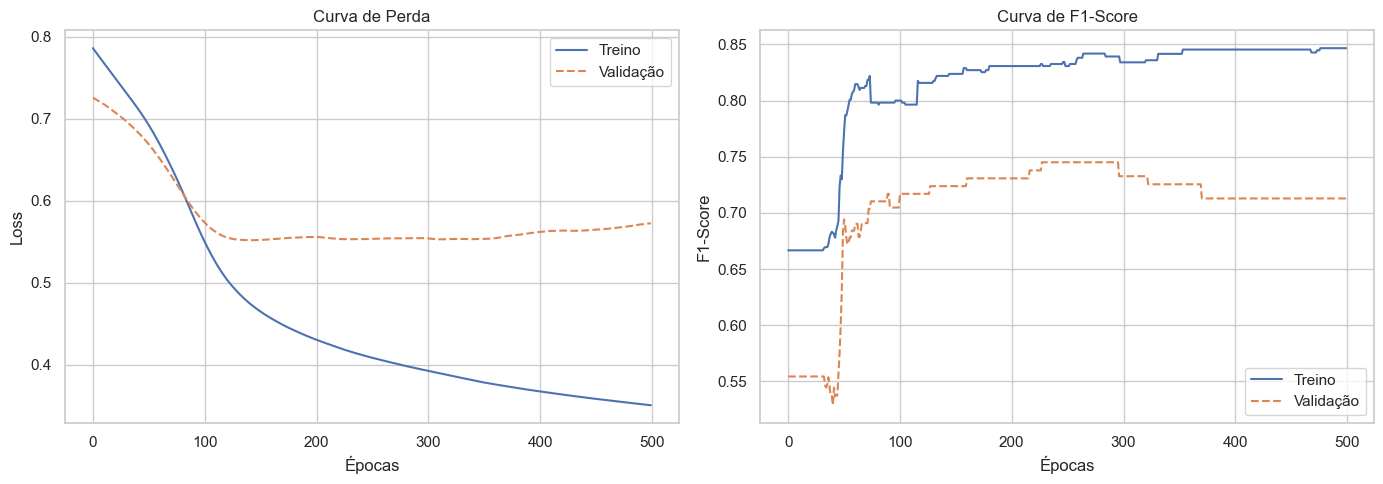

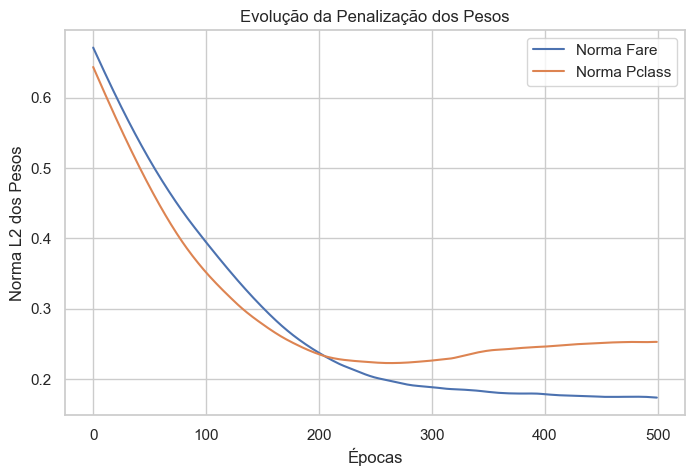


F1-Score no Teste: 0.7273
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        83
           1       0.75      0.71      0.73        51

    accuracy                           0.80       134
   macro avg       0.79      0.78      0.78       134
weighted avg       0.80      0.80      0.80       134



In [338]:
# Plotar curva de perda e F1-Score
plt.figure(figsize=(14, 5))

# Perda
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Treino')
plt.plot(val_loss_history, label='Validação', linestyle='--')
plt.title("Curva de Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# F1-Score
plt.subplot(1, 2, 2)
plt.plot(train_f1_history, label='Treino')
plt.plot(val_f1_history, label='Validação', linestyle='--')
plt.title("Curva de F1-Score")
plt.xlabel("Épocas")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evolução dos pesos penalizados
plt.figure(figsize=(8,5))
plt.plot(fare_weight_history, label='Norma Fare')
plt.plot(pclass_weight_history, label='Norma Pclass')
plt.title("Evolução da Penalização dos Pesos")
plt.xlabel("Épocas")
plt.ylabel("Norma L2 dos Pesos")
plt.legend()
plt.grid(True)
plt.show()

# Avaliação no Teste
model.eval()
with torch.no_grad():
    outputs_test = model(X_test_torch)
    preds_test = (outputs_test.cpu().numpy() > 0.5).astype(int)
    f1_test = f1_score(y_test, preds_test)

print(f"\nF1-Score no Teste: {f1_test:.4f}")
print(classification_report(y_test, preds_test))

In [339]:
# Avaliação no Teste

# Avaliação no Teste usando scikit-learn corretamente

y_test_pred = mlp_enriched.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)

print(f"\nF1-Score no Teste  usando scikit-learn sem penalização: {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))



# Avaliação no Teste usando MLP_Penalizado com torch

print(f"\nF1-Score no Teste com MLP_Penalizado com torch: {f1_test:.4f}")
print(classification_report(y_test, preds_test))


F1-Score no Teste  usando scikit-learn sem penalização: 0.7111
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        83
           1       0.82      0.63      0.71        51

    accuracy                           0.81       134
   macro avg       0.81      0.77      0.78       134
weighted avg       0.81      0.81      0.80       134


F1-Score no Teste com MLP_Penalizado com torch: 0.7111
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        83
           1       0.75      0.71      0.73        51

    accuracy                           0.80       134
   macro avg       0.79      0.78      0.78       134
weighted avg       0.80      0.80      0.80       134



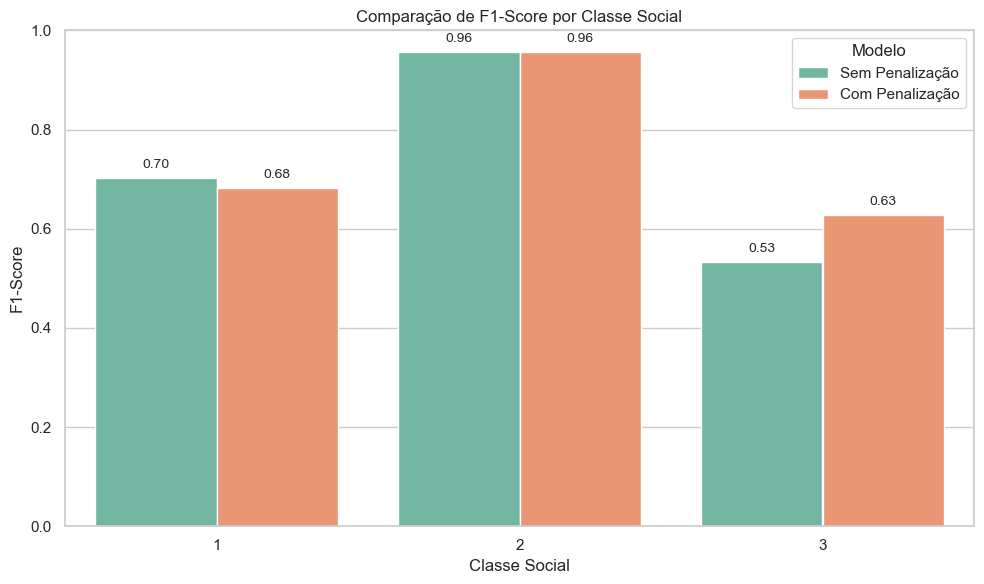

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score

def gerar_f1_por_classe(preds, y_true, X_test_df, original_df, nome_modelo):
    # Monta DataFrame de avaliação
    df = pd.DataFrame(X_test_df, index=y_true.index).copy()
    df['Survived_Real'] = y_true.values
    df['Survived_Pred'] = preds
    df['Pclass'] = original_df.loc[y_true.index, 'Pclass'].values

    resultados = []
    for p in [1, 2, 3]:
        subset = df[df['Pclass'] == p]
        f1 = f1_score(subset['Survived_Real'], subset['Survived_Pred'], zero_division=0) if len(subset) > 0 else 0
        resultados.append({'Classe': p, 'F1-Score': f1, 'Modelo': nome_modelo})
    
    return pd.DataFrame(resultados)

# Obter os resultados dos dois modelos
df_antes = gerar_f1_por_classe(mlp_enriched.predict(X_test), y_test, X_test, df_full, 'Sem Penalização')
df_depois = gerar_f1_por_classe(preds_test, y_test, X_test, df_full, 'Com Penalização')

# Combinar resultados
df_comparativo = pd.concat([df_antes, df_depois])

# Plotar os histogramas lado a lado
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comparativo, x='Classe', y='F1-Score', hue='Modelo', palette='Set2')
plt.title("Comparação de F1-Score por Classe Social")
plt.ylim(0, 1)
plt.xlabel("Classe Social")
plt.ylabel("F1-Score")
plt.legend(title='Modelo')

# Rótulos nas barras
for i, row in df_comparativo.iterrows():
    plt.text(
        x=row['Classe'] - 1 + (0.2 if row['Modelo'] == 'Com Penalização' else -0.2),
        y=row['F1-Score'] + 0.02,
        s=f"{row['F1-Score']:.2f}",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


###Interpretação do comportamento observado:
No início (época 0):

Os pesos da Fare e da Pclass começam com valores mais altos (Isso é esperado, pois a inicialização é aleatória).

Durante o treinamento:

A penalização força os pesos da Fare e da Pclass a diminuírem gradativamente.

O modelo é "empurrado" para depender menos dessas variáveis.

Os pesos chegam a um ponto de estabilização, onde continuam sendo pequenos, mas não zeram totalmente.

Isso acontece porque a penalização está equilibrando com dois objetivos:
Minimizar o erro de predição (nção de Perda de Entropia Cruzada Binária - BCELoss)
Reduzir os pesos de Fare e Pclass